<a href="https://colab.research.google.com/github/my-opencode/colaboratory-stable-diffusion/blob/main/StableDiffusion15LCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LCM Stable Diffusion Pipeline (SD 1.5)

### 1. Install dependencies

In [1]:
%pip install --quiet --upgrade diffusers accelerate peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 28.1 MB/s eta 0:00:00


### 2. Import libraries

In [2]:
from diffusers import StableDiffusionPipeline, LCMScheduler
import peft
import time
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [3]:
# @title 3. Settings & init pipeline
Run_Mode = "CPU" #@param ["CPU","GPU"]
Checkpoint = "Lykon/dreamshaper-8" #@param ["Lykon/dreamshaper-8", "digiplay/Photon_v1", "Lykon/dreamshaper-8-lcm"]
Lora = "latent-consistency/lcm-lora-sdv1-5" #@param ["none","latent-consistency/lcm-lora-sdxl","latent-consistency/lcm-lora-sdv1-5","latent-consistency/lcm-lora-ssd-1b"]

if (Run_Mode == "GPU") :
  pipeline = StableDiffusionPipeline.from_pretrained(
    Checkpoint,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
   )
else :
    StableDiffusionPipeline.from_pretrained(
    Checkpoint,
    use_safetensors=True,
    )

if(Lora != "none") :
  pipeline.load_lora_weights(Lora)
pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)

if (Run_Mode == "GPU") :
  pipeline = pipeline.to('cuda', dtype=torch.float16)
else :
  pipeline = pipeline.to('cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


pytorch_lora_weights.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/6 [00:00<?, ?it/s]

Elapsed time: 370.35527420043945 seconds


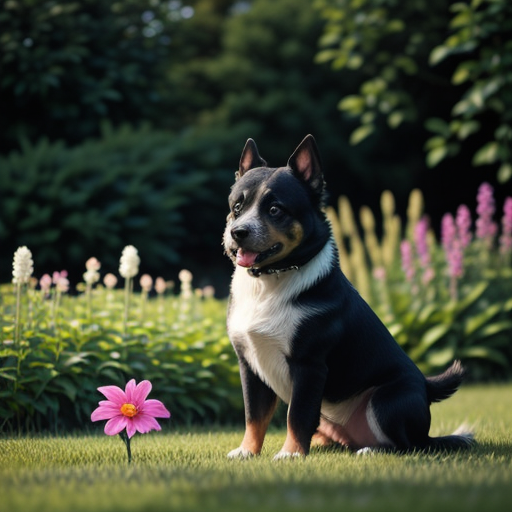

In [5]:
# @title 4. Sampler settings & render
prompt = "a dog in the garden" #@param {type:"string"}
seed = 1234567890 #@param {type:"integer"}
num_inference_steps = 6 #@param {type:"integer"}
guidance_scale = 1.8 #@param {type:"number"}
height = 512 #@param {type:"integer"}
width = 512 #@param {type:"integer"}

generator = torch.Generator("cpu").manual_seed(seed)
start_time = time.time()
image = pipeline(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    height=height,
    width=width,
    generator=generator
    ).images[0]
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")
image